# Initial hyper-parameter Sensitivity Study

This section will investigate the various sensitivty models and how a set of hyper-parameters effect the accuracy of the surrogate model.
The surrogate model is based off of a sodium fast reactor, whose design space ranges includes fuel height, smear, and plutonium content.
The objectives that the surrogate model is predicting are k-eff, void coefficent, and Doppler coefficient.
There are 60 datapoints in the database that the surrogate models can use to train on.

This section examines how various hyper-parameters effect the accuracy of the surrogate model, and examines a validation curve for each of the parameters.
The models will examine each objective independently, i.e. utilize the design inputs to map to only one objective, and as a whole.
Separating the objective will help differentiate how the hyper-parameters effects predicitions for each objective.

The cross-validation score is used to measure how the surrogate models fits the data to the model.
Typically, when both the training and cross-validation scores are low, it mean the surrogate model is unfitting.
If the training score is hight, but the cross-validation score is low, the surrogate model is overfitting the data, and is not able to accurately predict new values.
The ideal is to have the training and cross-validation score to be high, such that we are accurately predicting the objectives.

The hyper parameters will be given in the form: [min, max, # Iterations].
Each model has the random variable set to 0, to prevent results from changing between each examination.
It is noted that linear regression does not have any hyper-parameters, and is not listed below.

In [1]:
import train_surrogate_models as tm
import db_reshape as dbr
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection

warnings.filterwarnings("ignore")

var_tot, obj_tot = dbr.reshape_database(r'sfr_db.h5', ['height', 'smear', 'pu_content'], ['keff', 'void_coeff', 'doppler_coeff'])
var_tot, obj_keff = dbr.reshape_database(r'sfr_db.h5', ['height', 'smear', 'pu_content'], ['keff'])
var_tot, obj_void = dbr.reshape_database(r'sfr_db.h5', ['height', 'smear', 'pu_content'], ['void_coeff'])
var_tot, obj_dopp = dbr.reshape_database(r'sfr_db.h5', ['height', 'smear', 'pu_content'], ['doppler_coeff'])


data_col = ['model', 'r-squared', 'mean', 'std', 'hyper-parameters', 'cv_results']
sm_db = pd.DataFrame(columns = data_col)


## Polynomial Regression

Hyper-parameter: *Poly-Degree* - [1, 7, 1]

Results:

We note a few major aspect of the graphs to examine.
Polynomials of order greater than 4 provide dreadful results, which helps indicate that the underlying physics likely does not require polynomials of this degree.
Along with this, both k-eff and the void coefficient have a high cross-validation score for degree 2 and 3, whereas the doppler coefficient sees decrease in over 50% between these values.

This plummet carries over when all of the objective are examined in tandem.
For a polynomial of degree 2, the cross-validation score is ~0.95 and decreases to < 0.8 for a 3rd order polynomial.
This is likely due to the failure of the model to capture the Doppler coefficient.

For this particular database, it is suggested that between 1st and 3th order polynomials are examined.

keff


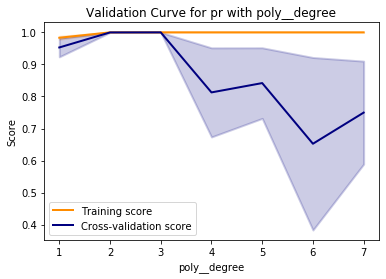

void


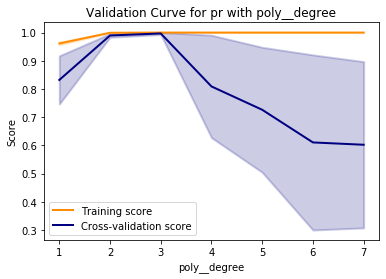

dopp


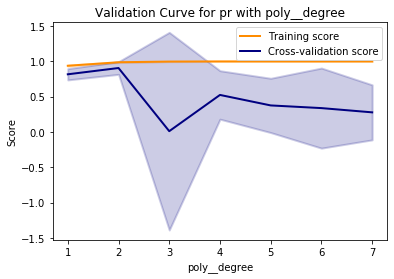

tot


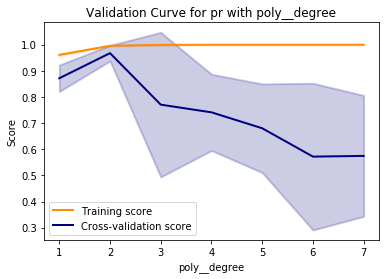

Poly Degree: {'poly__degree': 2}; Score 0.7895856837340269


In [2]:
sm = tm.Surrogate_Models()
model = 'pr'
name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0
    sm.update_database(var_tot, obj)
    sm.update_model(model)
    sm.plot_validation_curve(model, 'poly__degree', np.linspace(1,7,7,dtype=np.int16))
    sm.clear_surrogate_model()
    
sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[model,
                             score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('Poly Degree: {}; Score {}'.format(hp, score))


## Multi-Adaptive Regression Splines

Hyper-parameter: *endspan_alpha* - [0.01, 0.1, 100] <br />
                 *minspan_alpha* - [0.01, 0.1, 100] <br />
                 *penalty*       - [1, 10, 10] <br />
                 
Results:

The resulst for using MARS shows the ability to remove multiple hyper-parameters due to a relative insensitivity.
For *endspan_alpha*, there is little variation in cross-validation score for k-eff and the void coefficient.
For both the Doppler and the combined objectives, there is an increase of ~10% when varying the *endspan_alhpa*.
Given the relative invariance for k-eff and the void coeffificient, the value for *endspan_alpha* should be set close to 0.1 to take advantage of this.
It should be noted that additional cross-validation scores should be examined to ensure that increasing *endspan_alpha* does not negatively effect any of the other parameters.

The results for *minspan_alpha* indicate that none of the objective show any sensitivity to the values, and thus the default value should be used.

For the *penalty*, all of the objective show a similar trend.
There is considerable variation in the cross-validation score between 0 and 6, where after this it is relatively constant and produces a high cross-validation score.
Given the common trends among the objectives, it is recommended that the *penalty* be set to a value greater than 6.

For this dataset, an *endspan_alpha* of ~0.1 should be used with a penalty of >6, where the *minspan_alpha* shoudl be let as the default value.

keff


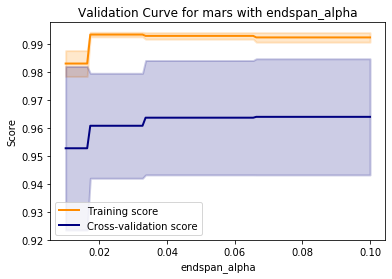

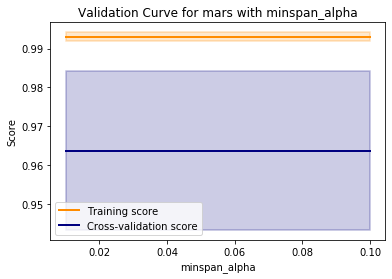

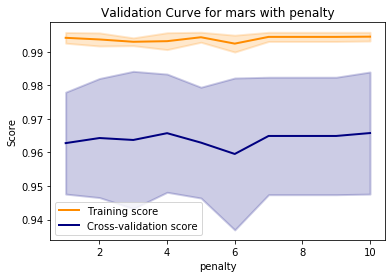


void


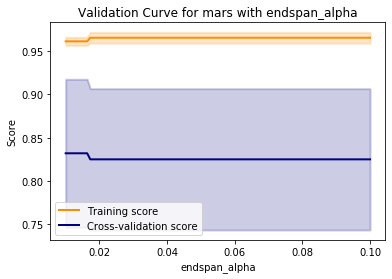

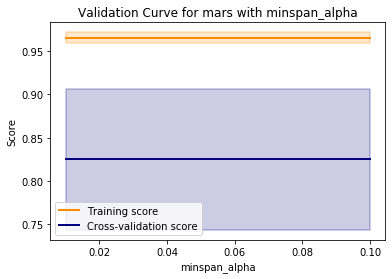

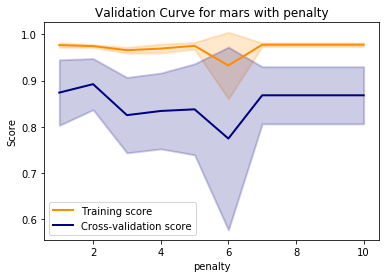


dopp


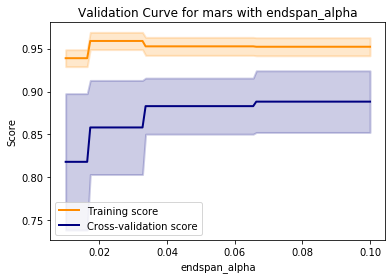

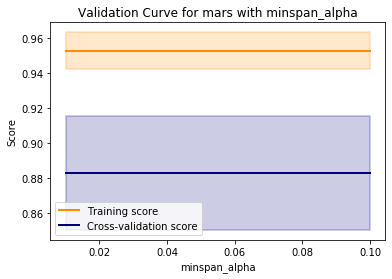

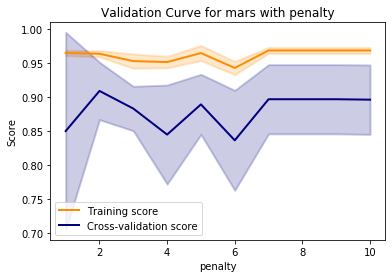


tot


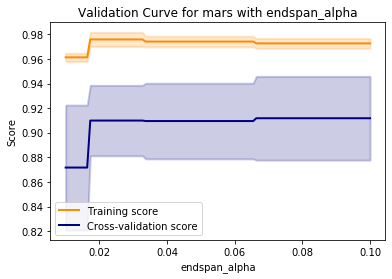

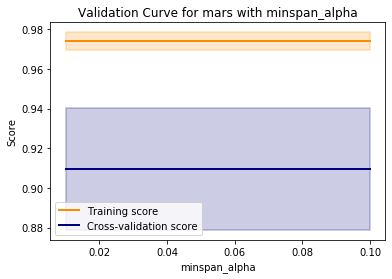

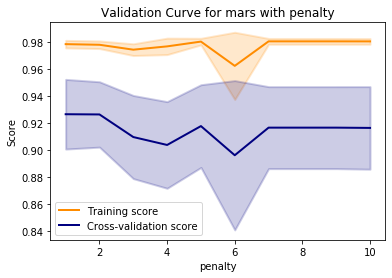


MARS Degree: {'endspan_alpha': 0.025}; Score 0.8197477296422229


In [3]:
sm = tm.Surrogate_Models()
model = 'mars'

name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0
    sm.update_database(var_tot, obj)
    sm.update_model(model)
    sm.plot_validation_curve(model, 'endspan_alpha', np.linspace(0.01,0.1,100))
    sm.plot_validation_curve(model, 'minspan_alpha', np.linspace(0.01,0.1,100))
    sm.plot_validation_curve(model, 'penalty', np.linspace(1,10,10))
    print('')
    sm.clear_surrogate_model()


sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[model,
                             score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('MARS Degree: {}; Score {}'.format(hp, score))

## Gaussian Process Regression

Hyper-parameter: alpha - [1e-11, 1e-9, 100]

Results:

For the Gaussian Process Regression, the only parameter examined here was *alpha*.
It was found that the cross-validation error is virtually invariant with respect to this parameter.
As such, the value for *alpha* should be left as the default value.

Notes:

There is another parameter to examine for GPR, namely the kernel used to evaluate the function.
Three kernels (*RBF*, *Matern*, *RotationalQuadratic*) are built into *train_surrogate_models*, however additional work is needed to be able to adjust the hyper-parameters of these kernels to examine the validation curve.
When this has been built in, additional results will be added

keff


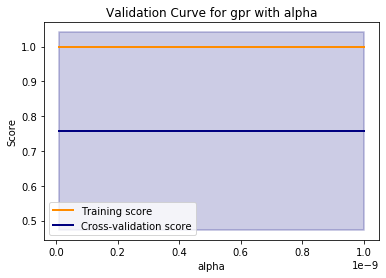


void


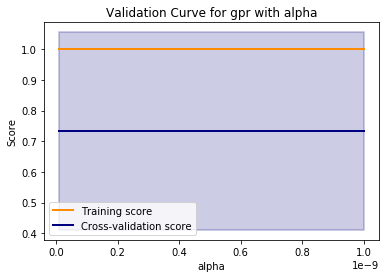


dopp


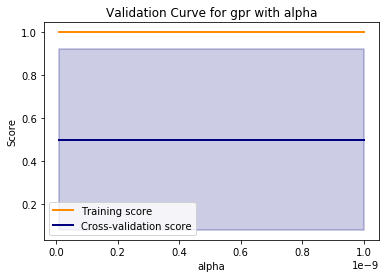


tot


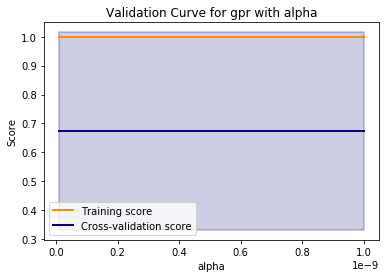


Poly Degree: {'kernel': Matern(length_scale=1, nu=1.5)}; Score 0.8986509198537418


In [4]:
from sklearn.gaussian_process.kernels import Matern, RBF, RationalQuadratic

sm = tm.Surrogate_Models()
model = 'gpr'

name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0
    sm.update_database(var_tot, obj)
    sm.update_model(model)
    sm.plot_validation_curve(model, 'alpha', np.linspace(1e-11,1e-9,100))
    print('')
    sm.clear_surrogate_model()


sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[model,
                             score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('Poly Degree: {}; Score {}'.format(hp, score))

## Artificial Neural Network

Hyper-parameter: *hidden_layer_size* - [1,50,50] <br />
                 *alpha*             - [0.00001,0.001,100]

Results:

Looking first at the results for *hidden_layer_size*, the trend for k-eff and the void coefficient is an increase in the cross-validaton score during the initial 1-20 hidden layers.
After this, the increase in the cross-validation score stagnates.
For the Doppler and total objectives, there is relatively little difference in the CV score due to the the number of hidden layers.
Overall, a value between 10 and 25 seems reasonable to capture the benefits of additional hidden layers.

The value of *alpha* is relatively noise and tends to hover around a constant value. As such, the recommended value is likely acceptable.

For this dataset, the *hidden_layer_size* shoudl be examined between 10 and 15, while the *alpha* can remain at its default value.


keff


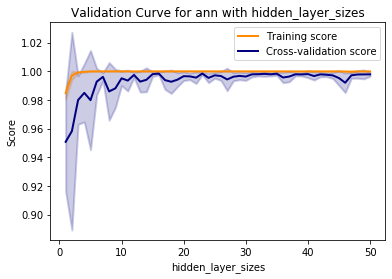

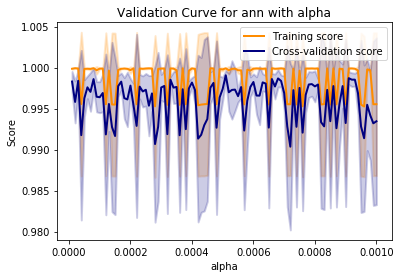


void


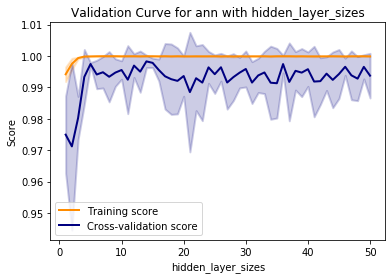

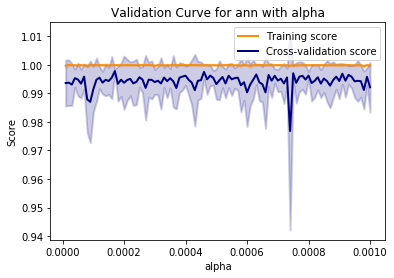


dopp


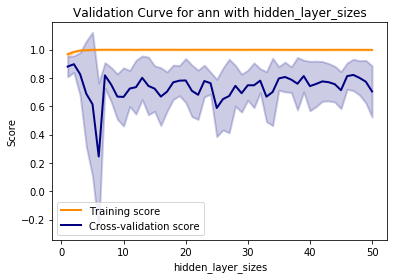

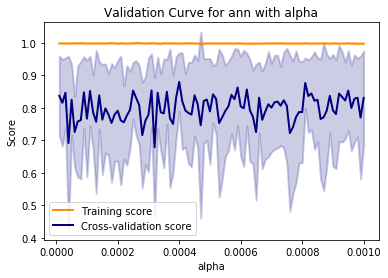


tot


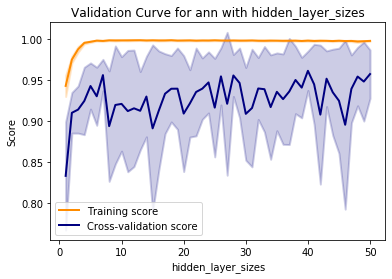

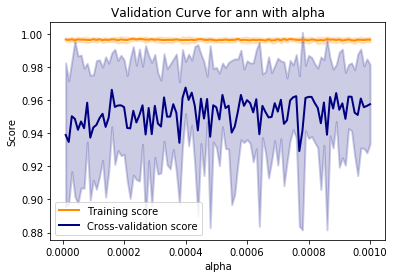


ANN: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': 50, 'solver': 'lbfgs'}; Score 0.7726093062814067


In [5]:
sm = tm.Surrogate_Models()
model = 'ann'

name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0 
    sm.update_database(var_tot, obj)
    sm.update_model(model)
    sm.plot_validation_curve(model, 'hidden_layer_sizes', np.linspace(1,50,50,dtype=np.int16))
    sm.plot_validation_curve(model, 'alpha', np.linspace(0.00001,0.001,100))
    print('')
    sm.clear_surrogate_model()


sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[model,
                             score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('ANN: {}; Score {}'.format(hp, score))

## Random Forests

Hyper-parameters: *n-estimators* - [10,500,490] <br />
*min_samples_leaf* - [1,10,10] <br />
*min_samples_split* - [1,10,10] <br />

Results:

For the *min_samples_leaf* and *min_samples_split*, increasing the minimum number of samples required to be considered at a leaf node or an internal node causes a significant decrease the the CV score.
For nearly all of the objectives, at a minimum of a 50% reduction in the CV score.
This indicates a high importance should be placed on the value for both *min_samples_leaf* and *min_samples_split*, where a values of 1 should be used for each to minimize the reductin in the CV score.

The *n-estimators* has a lower sensitivity compared to the previous hyper-parameters. 
Using a small number of estimators (<100) tend to produce slightly worse results on average, than thos using >100.
Despite this, the difference between 100 and 500, shows little improvement in the CV score, and thus a value in this range would seem appropriate.

For this data set, the *min_samples_leaf* and *min_samples_split* should be set to 1, while the *n-estimators* should be set between 100 and 500.

keff


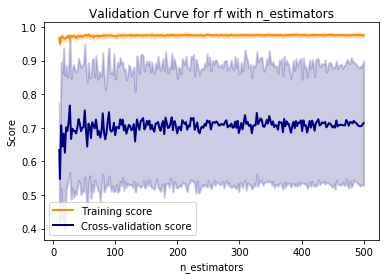

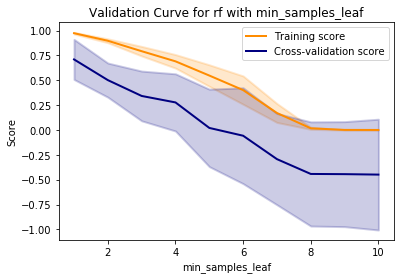

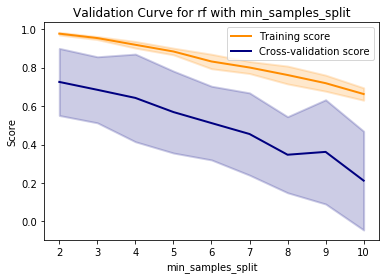


void


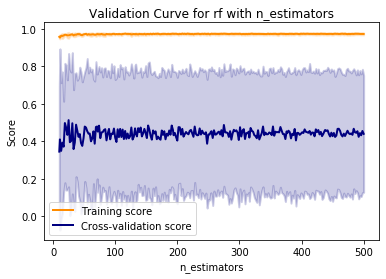

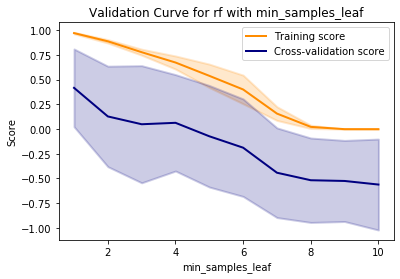

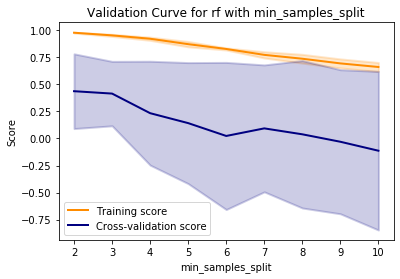


dopp


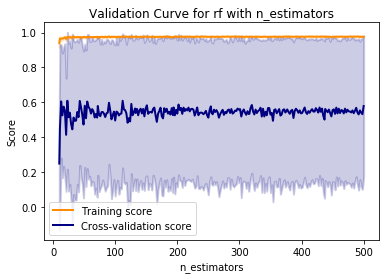

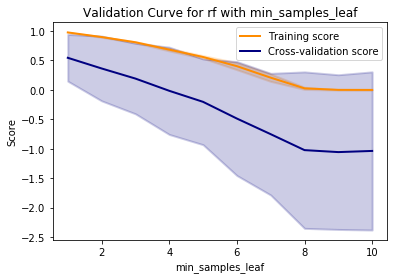

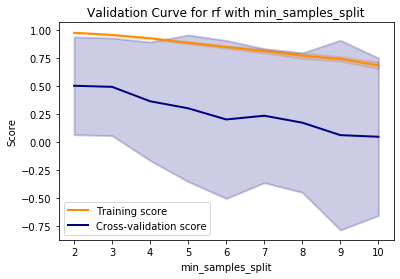


tot


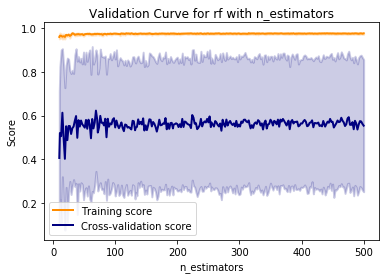

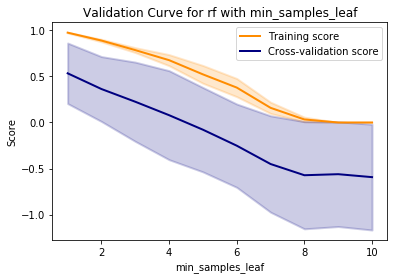

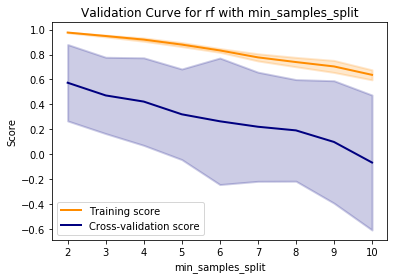


RM: {'n_estimators': 300}; Score 0.9564825465799635


In [6]:
sm = tm.Surrogate_Models()
model = 'rf'

name = ['keff', 'void', 'dopp', 'tot']
objective = [obj_keff, obj_void, obj_dopp, obj_tot]

for name, obj in zip(name, objective):
    print(name)
    sm.random = 0
    sm.update_database(var_tot, obj)
    sm.update_model(model)
    sm.plot_validation_curve(model, 'n_estimators', np.linspace(10,500,250,dtype=np.int16))
    sm.plot_validation_curve(model, 'min_samples_leaf', np.linspace(1,10,10,dtype=np.int16))
    sm.plot_validation_curve(model, 'min_samples_split', np.linspace(1,10,10,dtype=np.int16))

    print('')
    sm.clear_surrogate_model()


sm.update_database(var_tot, obj_tot)
sm.update_model(model)
sm.optimize_model(model)
score = sm.models[model]['score']
hp = sm.models[model]['hyper_parameters']
cv = sm.models[model]['cv_results']
append_dict = pd.DataFrame([[model,
                             score,
                             sm_db['r-squared'].mean(axis = 0),
                             sm_db['r-squared'].std(axis = 0),
                             hp,
                             cv]], columns=data_col)
sm_db = sm_db.append(append_dict)
print('RM: {}; Score {}'.format(hp, score))

In [11]:
sm_db

,model,r-squared,mean,std,hyper-parameters,cv_results
0,pr,0.789586,NaN,NaN,{'poly__degree': 2},"{'mean_fit_time': [0.0006258010864257813, 0.00..."
0,mars,0.819748,0.789586,NaN,{'endspan_alpha': 0.025},"{'mean_fit_time': [0.005661773681640625, 0.032..."
0,gpr,0.898651,0.804667,0.021328,"{'kernel': Matern(length_scale=1, nu=1.5)}","{'mean_fit_time': [0.0065974235534667965, 0.00..."
0,ann,0.772609,0.835995,0.056319,"{'activation': 'logistic', 'alpha': 0.0001, 'h...","{'mean_fit_time': [0.08953099250793457, 0.0946..."
0,rf,0.956483,0.820148,0.055848,{'n_estimators': 300},"{'mean_fit_time': [0.17802801132202148, 0.3187..."


## R-Squared

The last thing we examine is the R-squared value for each of the 'optimized' models.
R-squared is a measure of the proportion of variance in the dependent variables that is predictable by the independent variables.
Namely, this describes how well our model predicts the objectives

## Hyper-Parameter Conclusions

The previous section examined the effect of various hyper-parameters for the small database consisting of SFR reactor parameters.
For this research, it was determined that many of the hyper-parameters were unimportant, and do not require further tuning for this particular dataset.
However, this does not mean that these hyper-parameters of unimportant for all small dataset.
It simply means that relating the fuel height, smear, and plutonium fraction to k-eff, the void coefficient, and Doppler coefficient does not require these parameters.